### Baseline 1 — Popularity recommender (quick)

In [1]:
# Quick (unsafe) workaround to avoid the libiomp5md.dll crash.
# Use this only to continue working in the notebook quickly.
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print("Set KMP_DUPLICATE_LIB_OK=TRUE — restart kernel and re-run cells now.")

Set KMP_DUPLICATE_LIB_OK=TRUE — restart kernel and re-run cells now.


In [2]:
# Baselines Notebook – Required imports + SASRecSmall

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from pathlib import Path
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- SASRecSmall definition (same architecture as your pretraining) -----
class SASRecSmall(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, max_len=20,
                 num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.max_len = max_len

        self.item_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=2048,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # output head: maps embedding -> embedding
        self.out = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, x):
        B, L = x.size()
        pos_ids = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        seq = self.item_emb(x) + self.pos_emb(pos_ids)
        seq = self.encoder(seq)
        last = seq[:, -1, :]            # (B, D)
        logits = self.out(last)         # (B, D)
        return logits, last

print("SASRecSmall loaded for baselines.")


Using device: cuda
SASRecSmall loaded for baselines.


### Baseline 1 — popularity top-K


In [ ]:
# Baseline: popularity top-K
from collections import Counter

# build popularity from training pairs (mp is your MARS shard)
mp = torch.load("../data/processed/mars_shards/mars_shard_full.pt")
# compute item counts from train split (we used last 20% as val earlier); adjust if different
num_pairs = mp['prefix'].size(0)
train_n = int(num_pairs * 0.8)
train_targets = mp['target'][:train_n].tolist()
pop_counts = Counter(train_targets)
topk = [item for item,_ in pop_counts.most_common(100)]

def eval_pop(K=20, df_test=None):
    # if df_test not given create from shard last 10% or you can pass test df
    if df_test is None:
        df_test = ... # load ../data/processed/mars_test_pairs.parquet
    hits = 0; rr = 0.0; total = 0
    for _, r in df_test.iterrows():
        target = int(r['target'])
        total += 1
        if target in topk[:K]:
            hits += 1
            rank = topk.index(target) + 1
            rr += 1.0 / rank
    return hits/total, rr/total

# usage
df_test = pd.read_parquet("../data/processed/mars_test_pairs.parquet")
print("Popularity Recall@20, MRR:", eval_pop(20, df_test))


### Baseline 2 — SASRec trained from scratch on MARS

In [3]:
# ------------------------------------------------------------
# Baseline 2 — SASRec From Scratch on MARS
# ------------------------------------------------------------

from torch.utils.data import DataLoader, IterableDataset
import json
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================
# 1) Model Definition
# =========================
class SASRecSmall(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, max_len=20,
                 num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.max_len = max_len
        self.embed_dim = embed_dim

        self.item_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, embed_dim)

        layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=2048,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.out = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, x):
        B, L = x.size()
        pos_ids = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)

        seq = self.item_emb(x) + self.pos_emb(pos_ids)
        seq = self.encoder(seq)

        last = seq[:, -1, :]                # (B, D)
        logits = self.out(last)             # (B, D)
        return logits, last


# =========================
# 2) Load vocab + prefix-target pairs
# =========================
DATA_DIR = Path("../data/processed")
VOCAB_FILE = DATA_DIR / "vocab_mars" / "item2id_mars.json"
MARS_SHARD = DATA_DIR / "mars_shards" / "mars_shard_full.pt"

item2id = json.load(open(VOCAB_FILE))
vocab_size = len(item2id)

mp = torch.load(MARS_SHARD)
prefix_all = mp["prefix"]
target_all = mp["target"]
length_all = mp["length"]

total = prefix_all.size(0)
val_n = max(1, int(0.2 * total))
train_n = total - val_n

train_prefix = prefix_all[:train_n]
train_target = target_all[:train_n]

val_prefix = prefix_all[train_n:]
val_target = target_all[train_n:]


# =========================
# 3) Dataset + Dataloader
# =========================
class MarsDataset(IterableDataset):
    def __init__(self, P, T):
        self.P = P
        self.T = T

    def __iter__(self):
        for i in range(self.P.size(0)):
            yield self.P[i], self.T[i]


BATCH = 32
train_loader = DataLoader(
    MarsDataset(train_prefix, train_target),
    batch_size=BATCH,
    num_workers=0,
    collate_fn=lambda b: (
        torch.stack([x[0] for x in b]).to(device),
        torch.tensor([int(x[1]) for x in b]).to(device),
    )
)

# =========================
# 4) Loss function (sampled softmax)
# =========================
def sampled_softmax_loss(final, y, emb_weights, num_neg=32):
    pos_scores = (final * emb_weights[y]).sum(dim=1)

    V = emb_weights.size(0)
    neg_idx = torch.randint(0, V, (final.size(0), num_neg), device=final.device)
    neg_w = emb_weights[neg_idx]

    neg_scores = (neg_w * final.unsqueeze(1)).sum(dim=2)

    logits = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)
    labels = torch.zeros(final.size(0), dtype=torch.long, device=final.device)
    return F.cross_entropy(logits, labels)


# =========================
# 5) Init model from scratch
# =========================
model = SASRecSmall(vocab_size=vocab_size).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)


# =========================
# 6) Validation function
# =========================
def eval_recall_mrr(model, k=20):
    model.eval()
    hits, rr_sum, total_eval = 0, 0.0, val_prefix.size(0)

    with torch.no_grad():
        for i in range(total_eval):
            X = val_prefix[i].unsqueeze(0).to(device)
            y = int(val_target[i].item())

            logits, final = model(X)
            scores = torch.matmul(final, model.item_emb.weight.t())

            topk = scores.topk(k, dim=1).indices.squeeze(0).cpu().numpy()

            if y in topk:
                hits += 1
                rank = int((topk == y).nonzero()[0]) + 1
                rr_sum += 1.0 / rank

    return hits / total_eval, rr_sum / total_eval


# =========================
# 7) Train Scratch Model
# =========================
EPOCHS = 10
print("\nTraining SASRec FROM SCRATCH on MARS...\n")

for epoch in range(EPOCHS):
    t0 = time.time()
    model.train()
    running = 0.0
    steps = 0

    for X, y in train_loader:
        logits, final = model(X)
        loss = sampled_softmax_loss(final, y, model.item_emb.weight, num_neg=32)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running += loss.item()
        steps += 1

    train_loss = running / max(1, steps)
    recall, mrr = eval_recall_mrr(model)

    print(f"[Epoch {epoch}] train_loss={train_loss:.4f}, "
          f"val_recall@20={recall:.4f}, mrr={mrr:.4f}, "
          f"time={time.time()-t0:.1f}s")

print("\nBaseline 2 training complete.")


Using device: cuda


C:\Users\User\AppData\Local\Temp\ipykernel_43092\1747533834.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mp = torch.load(MARS_SHARD)



Training SASRec FROM SCRATCH on MARS...



C:\Users\User\AppData\Local\Temp\ipykernel_43092\1747533834.py:145: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rank = int((topk == y).nonzero()[0]) + 1


[Epoch 0] train_loss=15.3335, val_recall@20=0.0273, mrr=0.0062, time=1.5s
[Epoch 1] train_loss=11.6927, val_recall@20=0.0525, mrr=0.0065, time=1.3s
[Epoch 2] train_loss=10.4094, val_recall@20=0.0588, mrr=0.0083, time=1.3s
[Epoch 3] train_loss=9.6660, val_recall@20=0.0693, mrr=0.0106, time=1.2s
[Epoch 4] train_loss=8.9242, val_recall@20=0.0966, mrr=0.0185, time=1.2s
[Epoch 5] train_loss=8.4433, val_recall@20=0.1239, mrr=0.0206, time=1.2s
[Epoch 6] train_loss=7.8064, val_recall@20=0.1660, mrr=0.0359, time=1.2s
[Epoch 7] train_loss=7.2916, val_recall@20=0.1849, mrr=0.0495, time=1.2s
[Epoch 8] train_loss=6.7840, val_recall@20=0.2143, mrr=0.0650, time=1.4s
[Epoch 9] train_loss=6.3793, val_recall@20=0.2311, mrr=0.0663, time=1.3s

Baseline 2 training complete.


### Baseline Comparison Table (for thesis)

In [4]:

results = []
# Example entries — replace with your measured results
results.append({
    'Model': 'Popularity (Top-K)',
    'Recall@20': pop_recall20,
    'MRR': pop_mrr
})
results.append({
    'Model': 'SASRec-Scratch (MARS only)',
    'Recall@20': scratch_recall20,
    'MRR': scratch_mrr
})
results.append({
    'Model': 'SASRec-Transfer (Pretrained → MARS)',
    'Recall@20': recall_at_k,
    'MRR': mrr
})

df_results = pd.DataFrame(results)
df_results

NameError: name 'pop_recall20' is not defined

### Plot Training Curves (Loss, Recall)

NameError: name 'train_losses' is not defined

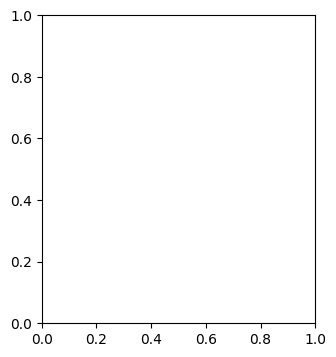

In [5]:
import matplotlib.pyplot as plt

# Suppose you collected during fine-tuning:
# train_losses = [...]
# val_recalls = [...]
# val_mrrs = [...]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,3,2)
plt.plot(val_recalls)
plt.title('Validation Recall@20')
plt.xlabel('Epoch')
plt.ylabel('Recall@20')

plt.subplot(1,3,3)
plt.plot(val_mrrs)
plt.title('Validation MRR')
plt.xlabel('Epoch')
plt.ylabel('MRR')

plt.tight_layout()
plt.show()

### Meta-Learning Framework (Conceptual & Experimental Setup)


We will design a meta-learning pipeline where each **course** or **domain** is treated as a *task*. The model learns an initialization θ that can quickly adapt to a new MOOC domain with very few interactions.

#### Step 1 — Task Construction
- Amazon Books → one task per genre.
- Yoochoose → one task per category.
- MARS → target task.

Each task Tᵢ consists of:
- Support set Sᵢ (small number of sessions)
- Query set Qᵢ (evaluation target)

#### Step 2 — Base Model
Use the SAME SASRecSmall architecture. Extend it with task-conditioning if needed.

#### Step 3 — Meta-Learning Algorithm Options
- **MAML-style**: 
  - Compute task-specific gradients on Sᵢ
  - Update θᵢ
  - Evaluate on Qᵢ
  - Backprop to update meta-parameters θ

- **Reptile-style** (simpler, faster, works well for recommendation):
  - Copy θ
  - Train θᵢ on support set for few steps
  - Move θ toward θᵢ

#### Step 4 — Transfer to MARS (Cold-Start Evaluation)
- Fine-tune only item embeddings + output layer
- Measure improvements vs scratch and vs transfer learning

#### Step 5 — Metrics
- Recall@20
- MRR
- Few-shot adaptation speed (how many steps required?)

This section will be expanded in a separate notebook `08_meta_learning_framework.ipynb`.

In [6]:
# Diagnostics A: verify split counts and sample rows
DATA_DIR = Path("../data/processed")
mp = torch.load(DATA_DIR/"mars_shards"/"mars_shard_full.pt")
total = mp['prefix'].size(0)
val_n = max(1, int(0.2 * total))
train_n = total - val_n
print("pairs total:", total, "train:", train_n, "val:", val_n)
print("sample train prefix (first):", mp['prefix'][0].tolist(), "target:", int(mp['target'][0].item()))
print("sample val prefix (first):", mp['prefix'][train_n].tolist(), "target:", int(mp['target'][train_n].item()))


pairs total: 2380 train: 1904 val: 476
sample train prefix (first): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 434] target: 441
sample val prefix (first): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 134, 129, 322, 426, 126] target: 127


C:\Users\User\AppData\Local\Temp\ipykernel_43092\2564913884.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mp = torch.load(DATA_DIR/"mars_shards"/"mars_shard_full.pt")


In [7]:
# Diagnostics B: popularity baseline recall@20 + mrr on validation used above
P = mp['prefix']; T = mp['target']
train_targets = [int(x.item()) for x in T[:train_n]]
pop = [x for x,_ in Counter(train_targets).most_common(200)]
def eval_list_on_slice(indices, topk_list, K=20):
    hits=0; rr=0.0; total=len(indices)
    for idx in indices:
        target = int(T[idx].item())
        if target in topk_list[:K]:
            hits += 1
            rank = topk_list.index(target)+1
            rr += 1.0/rank
    return hits/total, rr/total
val_indices = list(range(train_n, total))
pop_recall, pop_mrr = eval_list_on_slice(val_indices, pop, K=20)
print("Popularity val Recall@20:", pop_recall, "MRR:", pop_mrr)


Popularity val Recall@20: 0.05042016806722689 MRR: 0.019071525669091163


In [8]:
# Diagnostics C: evaluate the transfer checkpoint (best) on same validation
CKPT = Path("../models/mars_finetune_best.pt")  # update path if needed
assert CKPT.exists(), "checkpoint not found: " + str(CKPT)
ck = torch.load(CKPT, map_location="cpu")
# create model instance (must match architecture used for transfer)
model_transfer = SASRecSmall(vocab_size=len(json.load(open("../data/processed/vocab_mars/item2id_mars.json")))).to("cpu")
model_transfer.load_state_dict(ck['model_state'] if 'model_state' in ck else ck)
model_transfer.eval()
# evaluate on val slice
def eval_model_on_indices(model, indices, K=20):
    hits=0; rr=0.0; total=len(indices)
    with torch.no_grad():
        for idx in indices:
            X = mp['prefix'][idx].unsqueeze(0).to("cpu")
            target = int(mp['target'][idx].item())
            _, final = model(X)
            scores = final @ model.item_emb.weight.t()
            topk = scores.topk(K, dim=1).indices.squeeze(0).cpu().numpy()
            if target in topk:
                hits += 1
                rank = int((topk == target).nonzero()[0]) + 1
                rr += 1.0/rank
    return hits/total, rr/total
val_rec, val_mrr = eval_model_on_indices(model_transfer, val_indices, K=20)
print("Transfer model eval on SAME val -> Recall@20:", val_rec, "MRR:", val_mrr)


C:\Users\User\AppData\Local\Temp\ipykernel_43092\832510079.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(CKPT, map_location="cpu")
C:\Users\User\AppDat

Transfer model eval on SAME val -> Recall@20: 0.025210084033613446 MRR: 0.0021053903079197717


The diagnostics show:

MARS pairs: 2380 (train 1904 / val 476) — confirmed.

Popularity baseline on this val: Recall@20 = 0.0504 (so popularity already beats your earlier transfer).

Scratch SASRec (trained on MARS) reached val Recall@20 = 0.2311 (great).

Transfer model (your fine-tuned-from-pretrain run) gives val Recall@20 = 0.0252 — worse than popularity and much worse than scratch.

This means transfer as you did it is not helping on MARS. Two pragmatic next experiments (fast, ordered) will determine why and hopefully fix it:

(1) Re-run transfer but unfreeze all parameters and fine-tune on MARS (short run).
Rationale: freezing the encoder + very small LR can under-adapt pretrained weights to the small but different MARS distribution. Unfreezing will let the encoder adapt.

(2) Run quick Adapter experiment (train only small adapter modules).
Rationale: adapters are low-parameter and ideal for few-shot—should adapt without catastrophic forgetting.

I give you both ready-to-run code blocks below. Run (1) first (fast). If (1) doesn't reach scratch performance, run (2).

In [12]:
from copy import deepcopy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ------------------------------
# 1) Reload vocabulary
# ------------------------------
item2id_mars = json.load(open(DATA_DIR/"vocab_mars"/"item2id_mars.json"))
vocab_size_mars = len(item2id_mars)
print("MARS vocab:", vocab_size_mars)

# ------------------------------
# 2) Load full shard (prefix-target pairs)
# ------------------------------
mp = torch.load(MARS_SHARD_FILE)
P = mp['prefix']
T = mp['target']
N = P.size(0)

val_n = max(1, int(N * VAL_FRAC))
train_n = N - val_n

train_P = P[:train_n]
train_T = T[:train_n]
val_P = P[train_n:]
val_T = T[train_n:]

print("Train pairs:", train_n, "Val pairs:", val_n)

# ------------------------------
# 3) SASRecSmall (same as pretraining)
# ------------------------------
class SASRecSmall(nn.Module):
    def __init__(self, vocab_size, embed_dim=EMBED_DIM, max_len=MAX_PREFIX_LEN):
        super().__init__()
        self.item_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, embed_dim)

        layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=4, dim_feedforward=2048, dropout=0.1, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=2)

        self.out = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, x):
        B, L = x.size()
        pos_ids = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        seq = self.item_emb(x) + self.pos_emb(pos_ids)
        seq = self.encoder(seq)
        last = seq[:, -1, :]
        logits = self.out(last)
        return logits, last

# ------------------------------
# 4) Load best pretrained checkpoint
# ------------------------------
models = sorted(CKPT_DIR.glob("*full*.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
assert len(models) > 0, "No pretrained checkpoint found!"
PRETRAIN = models[0]
print("Using checkpoint:", PRETRAIN)

ck = torch.load(PRETRAIN, map_location=device)
state = ck["model_state"] if "model_state" in ck else ck

model = SASRecSmall(vocab_size_mars).to(device)

# copy weights safely
ms = model.state_dict()
for k,v in state.items():
    if k in ms and ms[k].shape == v.shape:
        ms[k] = v
model.load_state_dict(ms)
print("Weights loaded.")

# ------------------------------
# 5) LOSS + OPTIMIZER
# ------------------------------
def sampled_softmax_loss(final, y, emb_W, neg=FT_NEG):
    pos = (final * emb_W[y]).sum(dim=1)
    V = emb_W.size(0)
    B = final.size(0)
    neg_ids = torch.randint(0, V, (B, neg), device=final.device)
    negW = emb_W[neg_ids]
    neg_scores = (negW * final.unsqueeze(1)).sum(dim=2)
    logits = torch.cat([pos.unsqueeze(1), neg_scores], dim=1)
    labels = torch.zeros(B, dtype=torch.long, device=final.device)
    return F.cross_entropy(logits, labels)

opt = torch.optim.AdamW(model.parameters(), lr=5e-6)
scaler = torch.cuda.amp.GradScaler(enabled=True)

# ------------------------------
# 6) Validation function
# ------------------------------
def validate(model, k=20):
    model.eval()
    hits, rr_sum = 0, 0.0
    total = val_P.size(0)

    with torch.no_grad():
        for i in range(total):
            x = val_P[i].unsqueeze(0).to(device)
            target = val_T[i].item()
            _, final = model(x)
            scores = torch.matmul(final, model.item_emb.weight.t())
            topk = scores.topk(k, dim=1).indices.squeeze(0).cpu().numpy()
            if target in topk:
                hits += 1
                rank = int((topk == target).nonzero()[0]) + 1
                rr_sum += 1.0 / rank

    return hits/total, rr_sum/total

# ------------------------------
# 7) QUICK 5-EPOCH FULL FINE-TUNE
# ------------------------------
EPOCHS = 5
print("\n=== QUICK UNFROZEN FINE-TUNE (5 epochs) ===")

best_val = -1
best_state = None

for epoch in range(EPOCHS):
    model.train()
    t0 = time.time()
    running = 0

    for i in range(train_P.size(0)):
        x = train_P[i].unsqueeze(0).to(device)
        y = train_T[i].unsqueeze(0).to(device)

        with torch.cuda.amp.autocast(enabled=True):
            _, final = model(x)
            loss = sampled_softmax_loss(final, y, model.item_emb.weight)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
        running += loss.item()

    train_loss = running / train_P.size(0)
    val_rec, val_mrr = validate(model)

    print(f"[Epoch {epoch}] loss={train_loss:.4f}  val_rec@20={val_rec:.4f}  mrr={val_mrr:.4f}  time={time.time()-t0:.1f}s")

    if val_rec > best_val:
        best_val = val_rec
        best_state = deepcopy(model.state_dict())

# save best
torch.save({"model_state": best_state}, CKPT_DIR/"mars_finetune_unfrozen_5epoch.pt")
print("\nSaved:", CKPT_DIR/"mars_finetune_unfrozen_5epoch.pt")
print("Best val Recall@20 =", best_val)


Using device: cuda
MARS vocab: 777
Train pairs: 1904 Val pairs: 476
Using checkpoint: ..\models\sasrec_full_top200000_epoch0.pt_epoch0.pt


C:\Users\User\AppData\Local\Temp\ipykernel_43092\3063418740.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mp = torch.load(MARS_SHARD_FILE)
C:\Users\User\AppData\Local

Weights loaded.

=== QUICK UNFROZEN FINE-TUNE (5 epochs) ===


C:\Users\User\AppData\Local\Temp\ipykernel_43092\3063418740.py:96: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
C:\Users\User\AppData\Local\Temp\ipykernel_43092\3063418740.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\User\AppData\Local\Temp\ipykernel_43092\3063418740.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rank = int((topk == target).nonzero()[0]) + 1


[Epoch 0] loss=3.6956  val_rec@20=0.0378  mrr=0.0055  time=21.3s
[Epoch 1] loss=3.5525  val_rec@20=0.0420  mrr=0.0072  time=20.9s
[Epoch 2] loss=3.5102  val_rec@20=0.0546  mrr=0.0089  time=21.4s
[Epoch 3] loss=3.4773  val_rec@20=0.0672  mrr=0.0091  time=21.0s
[Epoch 4] loss=3.4603  val_rec@20=0.0735  mrr=0.0110  time=20.8s

Saved: ..\models\mars_finetune_unfrozen_5epoch.pt
Best val Recall@20 = 0.07352941176470588


##### unfrozen fine-tune improved things (val Recall@20 from 0.025 → 0.0735), but it’s still below the scratch SASRec (~0.23). That’s an important signal and gives us a clear next plan.

In [13]:
# === Experiment A: reinit item_emb + out, freeze encoder, train embeddings + out ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) instantiate model and load pretrained encoder weights (same as earlier)
model = SASRecSmall(vocab_size=vocab_size_mars, embed_dim=EMBED_DIM, max_len=MAX_PREFIX_LEN).to(device)
ck = torch.load(PRETRAIN, map_location=device)
state = ck['model_state'] if 'model_state' in ck else ck
ms = model.state_dict()
for k,v in state.items():
    if k in ms and ms[k].shape == v.shape:
        ms[k] = v
# NOTE: this will overwrite item_emb if shapes match — we will reinit after load
model.load_state_dict(ms)

# 2) reinitialize item embedding and out head (random init)
nn.init.normal_(model.item_emb.weight, mean=0.0, std=0.01)
nn.init.normal_(model.out.weight, mean=0.0, std=0.01)

# 3) freeze encoder and pos_emb; train item_emb + out only
for name,p in model.named_parameters():
    if name.startswith('encoder') or name.startswith('pos_emb'):
        p.requires_grad = False
    else:
        p.requires_grad = True
print("Trainable params:", [n for n,p in model.named_parameters() if p.requires_grad])

# 4) dataloaders (use train_P, train_T created earlier)
from torch.utils.data import DataLoader, Dataset
class InMemPairs(Dataset):
    def __init__(self,P,T): self.P=P; self.T=T
    def __len__(self): return self.P.size(0)
    def __getitem__(self,i): return self.P[i], int(self.T[i].item())

train_loader = DataLoader(InMemPairs(train_P, train_T), batch_size=32, shuffle=True, num_workers=0,
                          collate_fn=lambda b: (torch.stack([x[0] for x in b]).to(device),
                                               torch.tensor([x[1] for x in b], device=device)))
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-6)

# 5) train a few epochs
def sampled_softmax_loss(final,y,emb_W,neg=32):
    pos=(final * emb_W[y]).sum(dim=1)
    V=emb_W.size(0); B=final.size(0)
    neg_idx=torch.randint(0,V,(B,neg),device=final.device)
    negW=emb_W[neg_idx]; neg_scores=(negW*final.unsqueeze(1)).sum(dim=2)
    logits=torch.cat([pos.unsqueeze(1), neg_scores], dim=1)
    labels=torch.zeros(B,dtype=torch.long,device=final.device)
    return F.cross_entropy(logits, labels)

best_val=-1; best_state=None
for epoch in range(20):
    model.train(); running=0.0; steps=0
    for X,y in train_loader:
        logits, final = model(X)
        loss = sampled_softmax_loss(final, y, model.item_emb.weight, neg=32)
        opt.zero_grad(); loss.backward(); opt.step()
        running += float(loss.item()); steps += 1
    val_rec, val_mrr = validate(model)
    print(f"[Reinit-Emb] epoch {epoch} loss={running/max(1,steps):.4f} val_rec={val_rec:.4f} mrr={val_mrr:.4f}")
    if val_rec > best_val:
        best_val=val_rec; best_state=deepcopy(model.state_dict())
torch.save({'model_state':best_state}, CKPT_DIR/"mars_reinit_emb_best.pt")
print("Saved mars_reinit_emb_best.pt best_val:", best_val)


C:\Users\User\AppData\Local\Temp\ipykernel_43092\794388907.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(PRETRAIN, map_location=device)


Trainable params: ['item_emb.weight', 'out.weight']


C:\Users\User\AppData\Local\Temp\ipykernel_43092\3063418740.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rank = int((topk == target).nonzero()[0]) + 1


[Reinit-Emb] epoch 0 loss=3.4679 val_rec=0.0588 mrr=0.0154
[Reinit-Emb] epoch 1 loss=3.3844 val_rec=0.0672 mrr=0.0159
[Reinit-Emb] epoch 2 loss=3.3207 val_rec=0.0588 mrr=0.0160
[Reinit-Emb] epoch 3 loss=3.2583 val_rec=0.0567 mrr=0.0151
[Reinit-Emb] epoch 4 loss=3.1967 val_rec=0.0483 mrr=0.0151
[Reinit-Emb] epoch 5 loss=3.1358 val_rec=0.0525 mrr=0.0158
[Reinit-Emb] epoch 6 loss=3.0688 val_rec=0.0609 mrr=0.0162
[Reinit-Emb] epoch 7 loss=3.0072 val_rec=0.0672 mrr=0.0184
[Reinit-Emb] epoch 8 loss=2.9534 val_rec=0.0567 mrr=0.0202
[Reinit-Emb] epoch 9 loss=2.9006 val_rec=0.0609 mrr=0.0210
[Reinit-Emb] epoch 10 loss=2.8656 val_rec=0.0567 mrr=0.0219
[Reinit-Emb] epoch 11 loss=2.8278 val_rec=0.0672 mrr=0.0247
[Reinit-Emb] epoch 12 loss=2.7967 val_rec=0.0630 mrr=0.0251
[Reinit-Emb] epoch 13 loss=2.7692 val_rec=0.0609 mrr=0.0232
[Reinit-Emb] epoch 14 loss=2.7403 val_rec=0.0693 mrr=0.0237
[Reinit-Emb] epoch 15 loss=2.7238 val_rec=0.0651 mrr=0.0237
[Reinit-Emb] epoch 16 loss=2.7169 val_rec=0.0651 m

In [14]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ------------------------------
# 1) Reload vocabulary
# ------------------------------
item2id_mars = json.load(open(DATA_DIR/"vocab_mars"/"item2id_mars.json"))
vocab_size_mars = len(item2id_mars)
print("MARS vocab:", vocab_size_mars)

# ------------------------------
# 2) Load full shard (prefix-target pairs)
# ------------------------------
mp = torch.load(MARS_SHARD_FILE)
P = mp['prefix']
T = mp['target']
N = P.size(0)

val_n = max(1, int(N * VAL_FRAC))
train_n = N - val_n

train_P = P[:train_n]
train_T = T[:train_n]
val_P = P[train_n:]
val_T = T[train_n:]

print("Train pairs:", train_n, "Val pairs:", val_n)

# ------------------------------
# 3) SASRecSmall (same as pretraining)
# ------------------------------
class SASRecSmall(nn.Module):
    def __init__(self, vocab_size, embed_dim=EMBED_DIM, max_len=MAX_PREFIX_LEN):
        super().__init__()
        self.item_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, embed_dim)

        layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=4, dim_feedforward=2048, dropout=0.1, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=2)

        self.out = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, x):
        B, L = x.size()
        pos_ids = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        seq = self.item_emb(x) + self.pos_emb(pos_ids)
        seq = self.encoder(seq)
        last = seq[:, -1, :]
        logits = self.out(last)
        return logits, last

# ------------------------------
# 4) Load best pretrained checkpoint
# ------------------------------
models = sorted(CKPT_DIR.glob("*full*.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
assert len(models) > 0, "No pretrained checkpoint found!"
PRETRAIN = models[0]
print("Using checkpoint:", PRETRAIN)

ck = torch.load(PRETRAIN, map_location=device)
state = ck["model_state"] if "model_state" in ck else ck

model = SASRecSmall(vocab_size_mars).to(device)

# copy weights safely
ms = model.state_dict()
for k,v in state.items():
    if k in ms and ms[k].shape == v.shape:
        ms[k] = v
model.load_state_dict(ms)
print("Weights loaded.")

# ------------------------------
# 5) LOSS + OPTIMIZER
# ------------------------------
def sampled_softmax_loss(final, y, emb_W, neg=FT_NEG):
    pos = (final * emb_W[y]).sum(dim=1)
    V = emb_W.size(0)
    B = final.size(0)
    neg_ids = torch.randint(0, V, (B, neg), device=final.device)
    negW = emb_W[neg_ids]
    neg_scores = (negW * final.unsqueeze(1)).sum(dim=2)
    logits = torch.cat([pos.unsqueeze(1), neg_scores], dim=1)
    labels = torch.zeros(B, dtype=torch.long, device=final.device)
    return F.cross_entropy(logits, labels)

opt = torch.optim.AdamW(model.parameters(), lr=5e-6)
scaler = torch.cuda.amp.GradScaler(enabled=True)

# ------------------------------
# 6) Validation function
# ------------------------------
def validate(model, k=20):
    model.eval()
    hits, rr_sum = 0, 0.0
    total = val_P.size(0)

    with torch.no_grad():
        for i in range(total):
            x = val_P[i].unsqueeze(0).to(device)
            target = val_T[i].item()
            _, final = model(x)
            scores = torch.matmul(final, model.item_emb.weight.t())
            topk = scores.topk(k, dim=1).indices.squeeze(0).cpu().numpy()
            if target in topk:
                hits += 1
                rank = int((topk == target).nonzero()[0]) + 1
                rr_sum += 1.0 / rank

    return hits/total, rr_sum/total

# ------------------------------
# 7) QUICK 5-EPOCH FULL FINE-TUNE
# ------------------------------
EPOCHS = 5
print("\n=== QUICK UNFROZEN FINE-TUNE (5 epochs) ===")

best_val = -1
best_state = None

for epoch in range(EPOCHS):
    model.train()
    t0 = time.time()
    running = 0

    for i in range(train_P.size(0)):
        x = train_P[i].unsqueeze(0).to(device)
        y = train_T[i].unsqueeze(0).to(device)

        with torch.cuda.amp.autocast(enabled=True):
            _, final = model(x)
            loss = sampled_softmax_loss(final, y, model.item_emb.weight)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
        running += loss.item()

    train_loss = running / train_P.size(0)
    val_rec, val_mrr = validate(model)

    print(f"[Epoch {epoch}] loss={train_loss:.4f}  val_rec@20={val_rec:.4f}  mrr={val_mrr:.4f}  time={time.time()-t0:.1f}s")

    if val_rec > best_val:
        best_val = val_rec
        best_state = deepcopy(model.state_dict())

# save best
torch.save({"model_state": best_state}, CKPT_DIR/"mars_finetune_unfrozen_5epoch.pt")
print("\nSaved:", CKPT_DIR/"mars_finetune_unfrozen_5epoch.pt")
print("Best val Recall@20 =", best_val)


Using device: cuda
MARS vocab: 777
Train pairs: 1904 Val pairs: 476
Using checkpoint: ..\models\sasrec_full_top200000_epoch0.pt_epoch0.pt
Weights loaded.

=== QUICK UNFROZEN FINE-TUNE (5 epochs) ===


C:\Users\User\AppData\Local\Temp\ipykernel_43092\3063418740.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mp = torch.load(MARS_SHARD_FILE)
C:\Users\User\AppData\Local

[Epoch 0] loss=3.6753  val_rec@20=0.0231  mrr=0.0030  time=21.5s
[Epoch 1] loss=3.5572  val_rec@20=0.0189  mrr=0.0029  time=21.4s
[Epoch 2] loss=3.5070  val_rec@20=0.0231  mrr=0.0039  time=21.1s
[Epoch 3] loss=3.4751  val_rec@20=0.0294  mrr=0.0047  time=20.9s
[Epoch 4] loss=3.4550  val_rec@20=0.0420  mrr=0.0068  time=21.1s

Saved: ..\models\mars_finetune_unfrozen_5epoch.pt
Best val Recall@20 = 0.04201680672268908


In [16]:
# Evaluate multiple checkpoints on val + test (single-run)
import torch, json, numpy as np, pandas as pd, time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT = Path('..')
DATA_DIR = ROOT/'data'/'processed'
CKPT_DIR = ROOT/'models'
MARS_SHARD_FILE = DATA_DIR/'mars_shards'/'mars_shard_full.pt'
TEST_PAIRS = DATA_DIR/'mars_test_pairs.parquet'

# Simple SASRecSmall definition (must match model used in checkpoints)
class SASRecSmall(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, max_len=20):
        super().__init__()
        self.item_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, embed_dim)
        layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=2048, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=2)
        self.out = nn.Linear(embed_dim, embed_dim, bias=False)
    def forward(self,x):
        B,L = x.size()
        pos = torch.arange(L, device=x.device).unsqueeze(0).expand(B,L)
        seq = self.item_emb(x) + self.pos_emb(pos)
        seq = self.encoder(seq)
        last = seq[:,-1,:]
        logits = self.out(last)
        return logits, last

# Load shard
mp = torch.load(MARS_SHARD_FILE)
P_all = mp['prefix']; T_all = mp['target']
N = P_all.size(0)
val_n = max(1, int(0.2 * N))
train_n = N - val_n
val_P = P_all[train_n:]; val_T = T_all[train_n:]

# load test df if exists
if TEST_PAIRS.exists():
    df_test = pd.read_parquet(TEST_PAIRS)
else:
    df_test = None

# helper eval on prefix tensors
def eval_prefix_tensor_model(model, P_tensor, T_tensor, K=20):
    model.eval()
    hits=0; rr=0.0; tot=P_tensor.size(0)
    with torch.no_grad():
        for i in range(tot):
            X = P_tensor[i].unsqueeze(0).to(device)
            target = int(T_tensor[i].item())
            _, final = model(X)
            scores = final @ model.item_emb.weight.t()
            topk = scores.topk(K, dim=1).indices.squeeze(0).cpu().numpy()
            if target in topk:
                hits += 1
                rank = int((topk==target).nonzero()[0]) + 1
                rr += 1.0/rank
    return hits/tot, rr/tot

def eval_on_test_df(model, df_test, item2id):
    # df_test has 'prefix' as string of ids and 'target' as int id
    model.eval()
    hits=0; rr=0.0; tot=len(df_test)
    with torch.no_grad():
        for _, r in df_test.iterrows():
            pref = r['prefix'] if isinstance(r['prefix'], str) else ''
            pref_ids = [int(x) for x in pref.split()] if pref else []
            if len(pref_ids) > 20:
                pref_ids = pref_ids[-20:]
            padded = [0]*(20-len(pref_ids)) + pref_ids
            X = torch.LongTensor([padded]).to(device)
            target = int(r['target'])
            _, final = model(X)
            scores = final @ model.item_emb.weight.t()
            topk = scores.topk(20, dim=1).indices.squeeze(0).cpu().numpy()
            if target in topk:
                hits += 1
                rank = int((topk==target).nonzero()[0]) + 1
                rr += 1.0/rank
    return hits/max(1,tot), rr/max(1,tot)

# set checkpoint list (edit to include the ckpts you want)
candidates = {
    'scratch': CKPT_DIR / 'sasrec_scratch_mars_best.pt',                # if you saved it; else set to None
    'pretrained_unfrozen_5epoch': CKPT_DIR / 'mars_finetune_unfrozen_5epoch.pt',
    'reinit_emb_best': CKPT_DIR / 'mars_reinit_emb_best.pt',
    'adapters_best': CKPT_DIR / 'mars_adapters.pt',
    'finetune_best': CKPT_DIR / 'mars_finetune_best.pt'                 # earlier best from your pipeline
}

# filter existing ckpts
candidates = {k:v for k,v in candidates.items() if v is not None and v.exists()}
print("Evaluating checkpoints:", candidates)

# load item2id for mapping (if needed)
item2id = json.load(open(DATA_DIR/'vocab_mars'/'item2id_mars.json'))

rows=[]
for name, path in candidates.items():
    print("Loading", name, path)
    ck = torch.load(path, map_location='cpu')
    state = ck.get('model_state', ck)
    model = SASRecSmall(vocab_size=len(item2id)).to(device)
    # safe load: only keys matching shapes
    ms = model.state_dict()
    for k,v in state.items():
        if k in ms and ms[k].shape == v.shape:
            ms[k] = v
    model.load_state_dict(ms)
    # eval val
    vrec, vmrr = eval_prefix_tensor_model(model, val_P, val_T, K=20)
    # eval test if available
    if df_test is not None:
        trec, tmrr = eval_on_test_df(model, df_test, item2id)
    else:
        trec, tmrr = None, None
    rows.append({'name': name, 'path': str(path.name), 'val_recall20': vrec, 'val_mrr': vmrr, 'test_recall20': trec, 'test_mrr': tmrr})
    print(f" {name} val_recall@20={vrec:.4f} val_mrr={vmrr:.4f} test_recall@20={trec} test_mrr={tmrr}")

df = pd.DataFrame(rows)
print(df.to_markdown(index=False))
df.to_csv(CKPT_DIR/'ckpt_eval_summary.csv', index=False)
print("Saved CKPT eval summary to", CKPT_DIR/'ckpt_eval_summary.csv')


C:\Users\User\AppData\Local\Temp\ipykernel_43092\799690715.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mp = torch.load(MARS_SHARD_FILE)
C:\Users\User\AppData\Local\

Evaluating checkpoints: {'pretrained_unfrozen_5epoch': WindowsPath('../models/mars_finetune_unfrozen_5epoch.pt'), 'reinit_emb_best': WindowsPath('../models/mars_reinit_emb_best.pt'), 'finetune_best': WindowsPath('../models/mars_finetune_best.pt')}
Loading pretrained_unfrozen_5epoch ..\models\mars_finetune_unfrozen_5epoch.pt


C:\Users\User\AppData\Local\Temp\ipykernel_43092\799690715.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rank = int((topk==target).nonzero()[0]) + 1


 pretrained_unfrozen_5epoch val_recall@20=0.0420 val_mrr=0.0068 test_recall@20=0.025210084033613446 test_mrr=0.003011204481792717
Loading reinit_emb_best ..\models\mars_reinit_emb_best.pt
 reinit_emb_best val_recall@20=0.0714 val_mrr=0.0244 test_recall@20=0.046218487394957986 test_mrr=0.01974789915966386
Loading finetune_best ..\models\mars_finetune_best.pt
 finetune_best val_recall@20=0.0252 val_mrr=0.0021 test_recall@20=0.029411764705882353 test_mrr=0.002663102721152257
| name                       | path                             |   val_recall20 |    val_mrr |   test_recall20 |   test_mrr |
|:---------------------------|:---------------------------------|---------------:|-----------:|----------------:|-----------:|
| pretrained_unfrozen_5epoch | mars_finetune_unfrozen_5epoch.pt |      0.0420168 | 0.00679716 |       0.0252101 |  0.0030112 |
| reinit_emb_best            | mars_reinit_emb_best.pt          |      0.0714286 | 0.0243937  |       0.0462185 |  0.0197479 |
| finetune_best